# Training Lunar Lander with Q-Learning

TO DO:
- add normalization to inputs

## Setup and hyperparameters

In [2]:
import torch
from torch import nn, optim

import numpy as np
import random
import math
from collections import namedtuple, deque

import gymnasium as gym

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

The gymnasium page has this environment configurations, I'll go with them for now and change if I encounter any problems or want to test different parameters.

In [3]:
env = gym.make(
    "LunarLander-v2",
    continuous=False,
    gravity=-10.0,
    enable_wind=False,
    wind_power=15.0,
    turbulence_power=1.5,
)

Hyperparameters and global variables! I'll update the list as needed.

In [36]:
# Model's input and output
N_OBSERVATIONS = 8
N_ACTIONS = 4
CAPACITY = 10_000

EPS_START = 1.0
EPS_END = 0.1
EPS_DECAY = 9e-5
GAMMA = 0.99

BATCH_SIZE = 64
LEARNING_RATE = 1e-3

TRAIN = True

## Testing the environment

In [5]:
test_env = gym.make(
    "LunarLander-v2",
    continuous=False,
    gravity=-10.0,
    enable_wind=False,
    wind_power=15.0,
    turbulence_power=1.5,
    render_mode="human"
)

for _ in range(0):
    state, info = test_env.reset()
    terminated, truncated = False, False
    while not (terminated or truncated):
        action = test_env.action_space.sample()
        next_state, reward, terminated, truncated, info = test_env.step(action)

state, info = test_env.reset()
action = test_env.action_space.sample()
next_state, reward, _, _ , _= test_env.step(action)

test_env.close()

data = [state, action, next_state, reward]
print(data)
print(test_env.action_space)

[array([-0.00607796,  1.4121082 , -0.6156534 ,  0.05278005,  0.0070497 ,
        0.13945462,  0.        ,  0.        ], dtype=float32), 3, array([-0.01208868,  1.4127188 , -0.6063167 ,  0.02709705,  0.01223514,
        0.10371908,  0.        ,  0.        ], dtype=float32), 0.48552117641296033]
Discrete(4)


## Model class

There are many possible model settings. Since the input space is so small I'll start with a simple MLP. If that doesn't work I'll try more complicated architectures.

In [6]:
class RocketNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(N_OBSERVATIONS, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, N_ACTIONS)
        )

    def forward(self, x):
        logits = self.mlp(x)
        return logits

## Replay Memory

The replay memory will store observations up to a set capacity. After the memory has been filled to capacity, older observations will be discarted. The deque object deal with this automatically.

It'll be possible to sample elements of the memory. If the memory has fewer elements than have been inputted, the total amount of elements will be sampled instead.

What objects will be stores in memory? Tuples of the form (state, action, reward, next_state).

When sampling the returned objects shouldn't be the tuples, but rather 4 torch tensors with elements from the same tuple in the same index.

In [7]:
Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state', 'isnt_final'])

class ReplayMemory():
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def __len__(self):
        return len(self.memory)
    
    def push(self, state, action, reward, next_state, isnt_final):
        transition = Transition(state, action, reward, next_state, isnt_final)
        self.memory.append(transition)

    def sample(self, n_samples):
        total_samples = min(n_samples, len(self.memory))
        samples = random.sample(self.memory, total_samples)

        # Create torch array for each element in tuple
        state_sample = torch.from_numpy(np.vstack([t.state for t in samples]))
        action_sample = [t.action for t in samples]
        reward_sample = torch.tensor([t.reward for t in samples])
        next_state_sample = torch.from_numpy(np.vstack([t.next_state for t in samples]))
        isnt_final_sample = torch.tensor([t.isnt_final for t in samples])

        # Return all samples
        return state_sample, action_sample, reward_sample, next_state_sample, isnt_final_sample

Let's check if the class is working as expected

In [8]:
test_memory = ReplayMemory(100)

state, _ = env.reset()
terminated, truncated = False, False
while not (terminated or truncated):
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        isnt_final = 0
    else:
        isnt_final = 1
    test_memory.push(state, action, reward, next_state, isnt_final)
    state = next_state

samples = test_memory.sample(100)
for sample in samples:
    print(sample)

tensor([[ 0.7787,  0.9082,  1.3311, -1.0156, -0.9076, -0.4703,  0.0000,  0.0000],
        [ 0.4801,  1.3731,  0.9914, -0.4565, -0.6244, -0.0406,  0.0000,  0.0000],
        [ 0.4302,  1.4188,  1.0203, -0.3355, -0.6008, -0.1887,  0.0000,  0.0000],
        [ 0.6037,  1.2100,  1.1108, -0.6965, -0.6704, -0.1394,  0.0000,  0.0000],
        [ 0.2492,  1.5394,  0.7585, -0.1041, -0.4188, -0.3359,  0.0000,  0.0000],
        [ 0.7919,  0.8851,  1.3311, -1.0423, -0.9311, -0.4703,  0.0000,  0.0000],
        [ 0.2418,  1.5416,  0.7513, -0.0758, -0.4020, -0.3047,  0.0000,  0.0000],
        [ 0.6820,  1.0830,  1.1358, -0.8957, -0.7521, -0.2766,  0.0000,  0.0000],
        [ 0.3092,  1.5131,  0.7575, -0.2427, -0.5108, -0.2201,  0.0000,  0.0000],
        [ 0.9314,  0.6274,  1.4552, -1.2704, -1.1474, -0.4550,  0.0000,  0.0000],
        [ 0.3017,  1.5184,  0.7474, -0.2123, -0.4998, -0.1710,  0.0000,  0.0000],
        [ 0.0550,  1.4774,  0.6174,  0.2508, -0.0603, -0.1634,  0.0000,  0.0000],
        [ 0.8742

It's working! yay!

## Select action

I'll implement an epsilon-greedy action choice with epsilon decreasing linearly from 1.0 to 0.1 over the first 1e4 steps.

The action will depend on the model and state.

In [9]:
def select_action(model, state, steps_done):
    # Compute epsilon
    eps = max(EPS_END, EPS_START - EPS_DECAY * steps_done)
    rand = random.random()
    if rand <= eps:
        # Pick random action
        action = env.action_space.sample()
    else:
        with torch.no_grad(): # This won't be used for optimization
            tensor_state = torch.from_numpy(state)
            logits = model(tensor_state)
            action = torch.argmax(logits).item()
    return action

In [10]:
test_model = RocketNet()
state, _ = env.reset()
action = select_action(test_model, state, 10000)
print(action)

1


## Clear plot and display list of values

In [11]:
def update_plot(data, title="", datalabel="data", xlabel="", ylabel="", grid=True, sleep=0.5):
    clear_output(wait=True)
    plt.plot(data, label=datalabel)
    
    if len(data) >= 50:
        # Calculate the average of the last 100 data points
        avg_last_100 = [sum(data[i-49:i+1])/50 for i in range(49, len(data))]
        plt.plot(range(49, len(data)), avg_last_100)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(grid)
    plt.legend()
    plt.show()
    
    time.sleep(sleep)

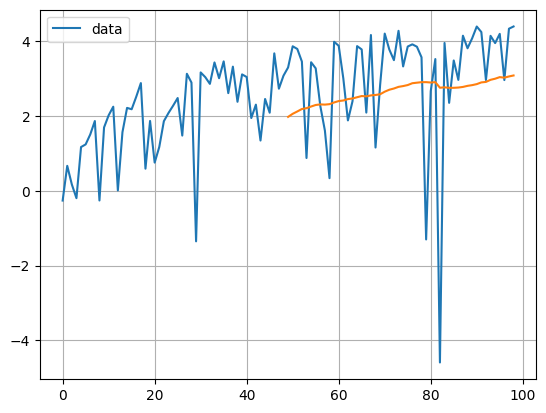

In [12]:
data = []
for i in range(1, 100):
    rand = math.log(i * random.random())
    data.append(rand)
    update_plot(data, datalabel="data", sleep=0.001)

## Normalize inputs

My training code wasn't working. One possible issue is that the inputs aren't normalized. I'll generate 1000 (maybe more) random samples and compute the mean and std deviation, and then use that to normalize all further inputs.

In [46]:
random_observations = np.zeros((10000, N_OBSERVATIONS), dtype='float32')

state, _ = env.reset()
for i in range(10000):
    random_observations[i] = state
    action = env.action_space.sample()
    state, _, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        state, _ = env.reset()

In [47]:
mean = random_observations.mean(axis=0)
std = random_observations.std(axis=0)
print(mean.dtype)
print(std.dtype)

float32
float32


In [48]:
def normalize_state(state):
    return (state - mean) / std

In [53]:
state, _ = env.reset()
print(normalize_state(state).dtype)

float32


## Training

In [55]:
if TRAIN:
    model = RocketNet()
    loss_fn = nn.SmoothL1Loss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, amsgrad=True)
    memory = ReplayMemory(CAPACITY)

In [54]:
def train_loop(model, loss_fn, optimizer, n_episodes, start_step=0):
    # Store total episode reward each episode
    rewards = []
    steps_done = start_step
    for _ in range(n_episodes):
        episode_reward = 0
        state, _ = env.reset()
        terminated, truncated = False, False
        while not (terminated or truncated):
            # Update step
            steps_done += 1
            
            # Normalize state
            norm_state = normalize_state(state)
            
            # Select and perform action
            action = select_action(model, norm_state, steps_done)
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Normalize next_state
            norm_next_state = normalize_state(next_state)

            # Declare if final or not
            if terminated or truncated:
                isnt_final = 0
            else:
                isnt_final = 1

            # Push transition into memory
            memory.push(norm_state, action, reward, norm_next_state, isnt_final)

            # Update state and episode reward
            norm_state = norm_next_state
            episode_reward += reward
            
            # Sample random batch
            state_batch, action_batch, reward_batch, next_state_batch, isnt_final_batch = memory.sample(BATCH_SIZE)

            # Compute Q(state, action) (lefthand-side of Bellman's eq)
            logits_batch = model(state_batch)
            pred = logits_batch[torch.arange(logits_batch.size(0)), action_batch]

            # Compute target (righthand-side of Bellman's eq)
            next_logits_batch = model(next_state_batch)
            next_pred = torch.max(next_logits_batch, dim=1).values
            target = reward_batch + GAMMA * next_pred * isnt_final_batch

            # Compute loss and optimize
            loss = loss_fn(target, pred)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        rewards.append(episode_reward)
        update_plot(rewards, title="Episode rewards", datalabel="rewards", xlabel="Episode", ylabel="Reward", grid=True, sleep=0.001)

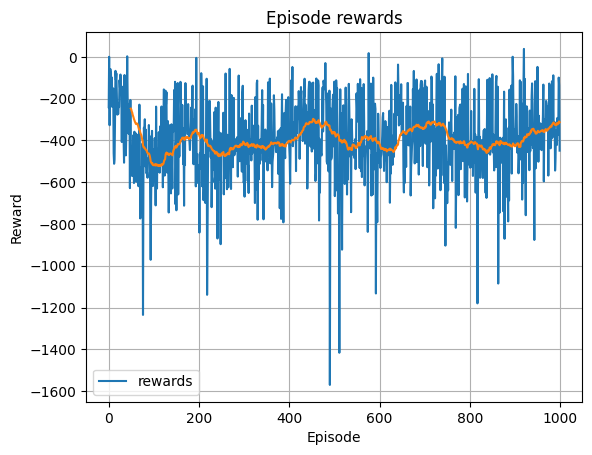

In [56]:
if TRAIN:
    train_loop(model, loss_fn, optimizer, 1000, 0)

## Test model

In [17]:
def test_model(model, env, n_episodes):
    for _ in range(n_episodes):
        state, _ = env.reset()
        terminated, truncated = False, False
        while not (terminated or truncated):
            action = select_action(model, state, 10000)
            next_state, _, terminated, truncated, _ = env.step(action)
            state = next_state
    env.close()

In [18]:
test_env = gym.make(
    "LunarLander-v2",
    continuous=False,
    gravity=-10.0,
    enable_wind=False,
    wind_power=15.0,
    turbulence_power=1.5,
    render_mode="human"
)

In [19]:
#test_model(model, test_env, 2)

In [20]:
# torch.save(model.state_dict(), 'LunarLander-v2_model1.pth')